#  Setup

In [1]:
%pylab inline
from matplotlib import gridspec
import inspect, warnings
from scipy import constants
from scipy.optimize import curve_fit

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['TeX Gyre Termes','Times','Times New Roman'],'size':10.0})
rc('axes',**{'labelsize':'large'})
rc('text', usetex=False)
rc('figure', figsize=(4,3))
rc('mathtext', fontset='stix')
rc('pdf',**{'fonttype': 42})
from cycler import cycler
linestyle_cycler = cycler('linestyle', ['-', '--', ':', '-.'])

In [3]:
def read_xvg(filename):
    '''A little auxiliary function to read a GROMACS-produced XVG
    file, automatially skipping over the default xmgr formatting.'''
    
    skiplines = 0
    with open(filename, 'rt') as xvgfile:
        for line in xvgfile:
            if line[0] in ('#','@'):
                skiplines += 1
                continue
            else:
                break
            
    return np.loadtxt(filename, skiprows=skiplines)

In [4]:
def report_params(function, params, covar):
    print('parameters (± 2 standard deviations):')
    variances = np.diagonal(covar)
    for param, var, name in zip(params, variances, list(inspect.signature(function).parameters.keys())[1:]):
        print('  {} = {:20.16g} ± {:20.16g}'.format(name, param, 2*np.sqrt(var)))

# Load velocities and make histograms 

In [5]:
vel_hists = {}
for temperature in (100,200,300):
    vel_filename = 'vels_{}.xvg'.format(temperature)
    veldata = read_xvg(vel_filename)
    # Convert from nm/ps (km/s) to m/s
    vx = veldata[:,1:]*1000
    (vx_f, vx_bounds) = histogram(vx, 50, normed=True)
    vx_centers = (vx_bounds[:-1] + vx_bounds[1:])/2.0    
    del veldata
    
    vel_hists[temperature] = {'f': vx_f,
                              'bounds': vx_bounds,
                              'centers': vx_centers}

#  Exploratory analysis for 100 K

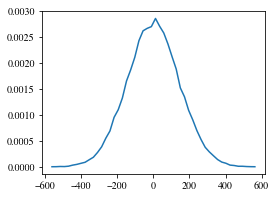

In [6]:
f = vel_hists[100]['f'] # probability density
vx = vel_hists[100]['centers'] # x velocity
plot(vx,f)

This looks like a Gaussian function of the velocities. The simplest Gaussian function of velocities that we can come up with is
$$
f(v_x) = A\exp\left(-b v_x^2 \right)
$$
where $A$ sets the overall height of the curve and $b$ scales the width.

In [7]:
# Define our model function
def model(vel, A, b):
    return A*exp(-b*vel**2)

In [8]:
# Fit our model function
params, covar = curve_fit(model,           # function to fit
                          vx,      # x values
                          f,            # y values
                          [0.003, 1/200.0] # initial parameters
                          )
report_params(model, params, covar)

parameters (± 2 standard deviations):
  A = 0.002768293143855151 ± 2.166837530426005e-05
  b = 2.415447099347286e-05 ± 4.366287816231615e-07


/usr/local/Cellar/ipython/6.2.1/libexec/vendor/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Calculate our predicted velocity distribution and residual
fit = model(vx, *params)
residual = f - fit

/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1121: UserWarning: 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


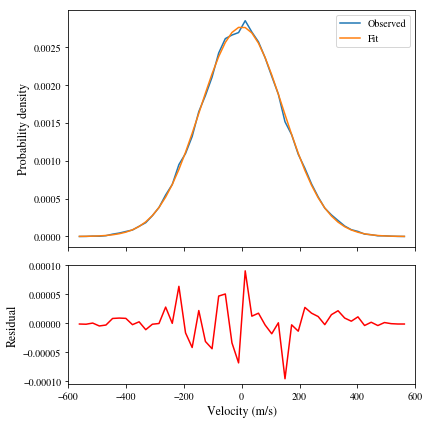

In [10]:
# Plot our distribution and residual
fig = figure(figsize=(6,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax1.plot(vx, f, label='Observed')
ax1.plot(vx, fit, label='Fit')
ax1.set_ylabel('Probability density')
ax1.legend()
setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(vx, residual, color='red')
ax2.set_xlabel('Velocity (m/s)')
ax2.set_ylabel('Residual')

xlim(-600,600)
tight_layout()

# Save a PDF for later use
savefig('100K_b_fit.pdf')

Now, $v^2$ also appears in the expression for kinetic energy: $E = (1/2)mv^2$. That means that the exponent of our function is within a constant of having units of energy. Let's make that more explicit by introducing the mass of our particles:
$$
f(v_x) = A\exp\left(-c\cdot\frac{1}{2}mv_x^2\right)
$$
where $m$ is the mass of one of our particles and $c$ is a new constant to be determined by fitting.

In [11]:
# Define our model function
m = 39.948 / 1000.0 #kg/mol
def model(vel, A, c):
    return A*exp(-c*1/2*m*vel**2)

In [12]:
# Fit our model function
params, covar = curve_fit(model,           # function to fit
                          vx,      # x values
                          f,            # y values
                          [0.003, 1/200.0] # initial parameters
                          )
report_params(model, params, covar)

# Calculate our predicted velocity distribution and residual
fit = model(vx, *params)
residual = f - fit

parameters (± 2 standard deviations):
  A = 0.002768293101053496 ± 2.166835129420121e-05
  c = 0.001209295559331333 ± 2.185975990024694e-05


/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1121: UserWarning: 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


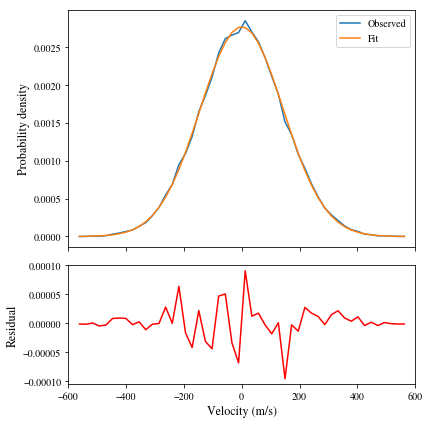

In [13]:
# Plot our distribution and residual
fig = figure(figsize=(6,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax1.plot(vx, f, label='Observed')
ax1.plot(vx, fit, label='Fit')
ax1.set_ylabel('Probability density')
ax1.legend()
setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(vx, residual, color='red')
ax2.set_xlabel('Velocity (m/s)')
ax2.set_ylabel('Residual')

xlim(-600,600)
tight_layout()

# Save a PDF for later use
savefig('100K_c_fit.pdf')

As expected, nothing but the magnitude and units of our width constant changed. Let's see how this changes from temperature to temperature.


=== Temperature = 100 K ===
parameters (± 2 standard deviations):
  A = 0.002768293101053496 ± 2.166835129420121e-05
  c = 0.001209295559331333 ± 2.185975990024694e-05


/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1121: UserWarning: 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))



=== Temperature = 200 K ===
parameters (± 2 standard deviations):
  A = 0.001928486137791654 ± 1.314234970210681e-05
  c = 0.0005833494824140622 ± 9.180911832542396e-06

=== Temperature = 300 K ===
parameters (± 2 standard deviations):
  A = 0.001618250020137457 ± 8.990526375650267e-06
  c = 0.0004134157750295512 ± 5.304304296404857e-06


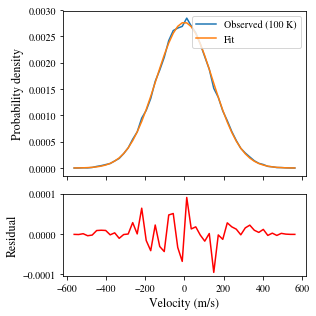

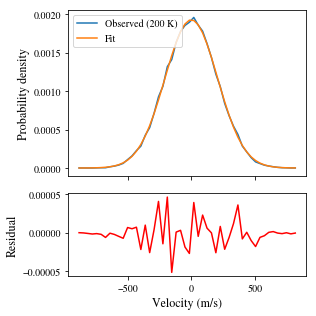

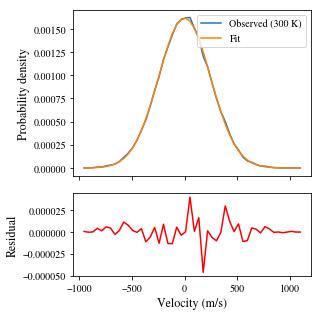

In [14]:
fit_params = {}

for temperature in (100,200,300):
    print('\n=== Temperature = {} K ==='.format(temperature))
    f = vel_hists[temperature]['f'] # probability density
    vx = vel_hists[temperature]['centers'] # x velocity
    
    # Fit our model function
    params, covar = curve_fit(model,           # function to fit
                              vx,      # x values
                              f,            # y values
                              [0.003, 1/200.0] # initial parameters
                              )
    fit_params[temperature] = (params,covar)
    report_params(model, params, covar)
    # Calculate our predicted velocity distribution and residual
    fit = model(vx, *params)
    residual = f - fit    
    
    # Plot
    fig = figure(figsize=(4.5,4.5))

    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(vx, f, label='Observed ({} K)'.format(temperature))
    ax1.plot(vx, fit, label='Fit')
    ax1.set_ylabel('Probability density')
    ax1.legend()
    setp(ax1.get_xticklabels(), visible=False)

    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(vx, residual, color='red')
    ax2.set_xlabel('Velocity (m/s)')
    ax2.set_ylabel('Residual')

    tight_layout()

    # Save a PDF for later use
    savefig('{}K_c_fit.pdf'.format(temperature))


Interesting. It looks like the constant $c$ is halved when going from 100 K to 200 K, and is reduced by a factor of 3 when going from 100 K to 300 K. This suggests that we might build temperature into our model. Let's define
$$
c = \frac{g}{T}
$$
so that our model becomes
$$
f(v_x) = A\exp\left(-\frac{g}{T}\cdot\frac{1}{2}mv_x^2 \right)
$$

In [15]:
# Define our model function
m = 39.948 / 1000.0 #kg/mol
def model(vel, A, c):
    return A*exp(-c*1/2*m*vel**2)

def make_model(T):
    def model(vel, A, g):
        return A*exp(-g/T*1/2*m*vel**2)
    return model

In [16]:
real_temperatures = (97.409, 193.466, 299.729)


=== Temperature = 100 K ===
parameters (± 2 standard deviations):
  A = 0.002768293147082732 ± 2.16683769297734e-05
  g =   0.1177962789460325 ± 0.002129347532310235


/usr/local/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1121: UserWarning: 'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))



=== Temperature = 200 K ===
parameters (± 2 standard deviations):
  A = 0.001928486136309662 ± 1.314235277492855e-05
  g =    0.112858290620666 ± 0.001776195856305297

=== Temperature = 300 K ===
parameters (± 2 standard deviations):
  A = 0.001618249995884264 ± 8.990513207584492e-06
  g =   0.1239126894003861 ± 0.001589844580604387


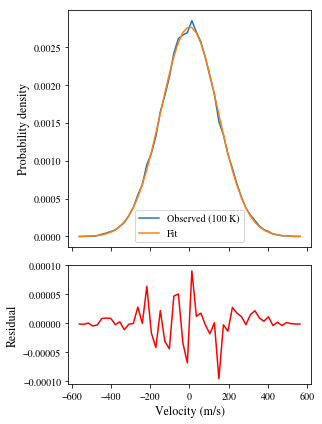

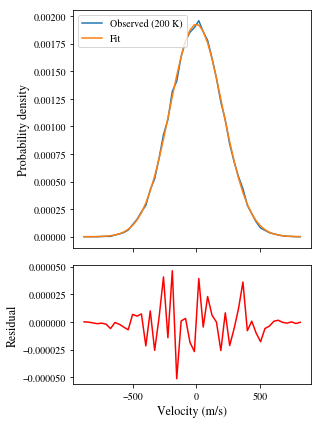

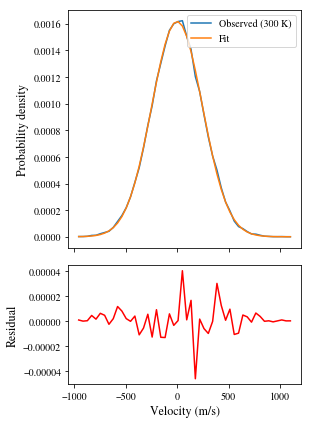

In [17]:
fit_params = {}
for temperature, real_temperature in zip((100,200,300), real_temperatures):
    print('\n=== Temperature = {} K ==='.format(temperature))
    f = vel_hists[temperature]['f'] # probability density
    vx = vel_hists[temperature]['centers'] # x velocity
    
    # Fit our model function
    model = make_model(real_temperature)
    params, covar = curve_fit(model,           # function to fit
                              vx,      # x values
                              f,            # y values
                              [0.003, 1/200.0] # initial parameters
                              )
    fit_params[temperature] = (params,covar)
    report_params(model, params, covar)
    # Calculate our predicted velocity distribution and residual
    fit = model(vx, *params)
    residual = f - fit    
    
    # Plot
    fig = figure(figsize=(4.5,6))

    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(vx, f, label='Observed ({} K)'.format(temperature))
    ax1.plot(vx, fit, label='Fit')
    ax1.set_ylabel('Probability density')
    ax1.legend()
    setp(ax1.get_xticklabels(), visible=False)

    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(vx, residual, color='red')
    ax2.set_xlabel('Velocity (m/s)')
    ax2.set_ylabel('Residual')

    tight_layout()

    # Save a PDF for later use
    savefig('{}K_g_fit.pdf'.format(temperature))


Interesting. All three $g$ values are the same to within error. They also have units of mol.K/J. I wonder if $g$ is related to the gas constant $R$?

In [18]:
gs = np.fromiter([p[0][1] for p in fit_params.values()],dtype=np.float32)
print(gs.mean())

0.118189


In [19]:
(1/gs).mean()

8.4733667

In [20]:
2*(1/gs).std()/np.sqrt(3)

0.3728567581162926